In [18]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

ImportError: cannot import name 'test_render' from 'rendering' (/Users/jorgemuyo/Desktop/CraftReplicator/rendering.py)

# Camera / Dataset

In [2]:
batch_size = 1024

o, d, target_px_values= get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3),
                                   torch.from_numpy(d).reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)

dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3),
                                   torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3)), dim=1),
                       batch_size=batch_size, shuffle=True)

# Model

In [ ]:
img = rendering(model, torch.from_numpy(o[-1]), torch.from_numpy(d[-1]), 8, 12)

plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

# Training

In [7]:
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

tensor([1.], device='mps:0')


100%|█████████████████████████████████████████████████████| 14063/14063 [41:46<00:00,  5.61it/s]


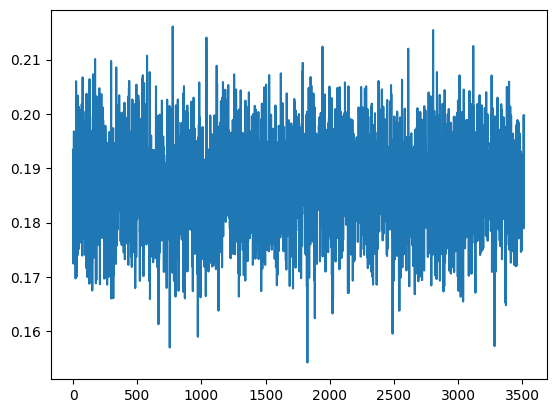

In [8]:
# APPLE SILLICON 
# ml_helpers transformation float32 2 float64

device = 'mps'

tn = 8
tf = 12
nb_epochs = 15
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader_warmup, device=device)
plt.plot(training_loss)
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)

In [16]:
img = rendering(model, 
                torch.from_numpy(o[1]).to(torch.float32).to(device),  # Convert after tensor creation
                torch.from_numpy(d[1]).to(torch.float32).to(device), 
                tn, tf, nb_bins=100, device=device)

RuntimeError: MPS backend out of memory (MPS allocated: 18.07 GB, other allocations: 704.00 KB, max allowed: 18.13 GB). Tried to allocate 183.11 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

Model parameters:
block1.0.weight: -0.0022 (mean), 0.0790 (std)
block1.0.bias: -0.0036 (mean), 0.0722 (std)
block1.2.weight: -0.0000 (mean), 0.0361 (std)
block1.2.bias: -0.0022 (mean), 0.0356 (std)
block1.4.weight: 0.0000 (mean), 0.0361 (std)
block1.4.bias: -0.0027 (mean), 0.0363 (std)
block1.6.weight: 0.0000 (mean), 0.0360 (std)
block1.6.bias: -0.0053 (mean), 0.0363 (std)
block1.8.weight: 0.0001 (mean), 0.0361 (std)
block1.8.bias: 0.0046 (mean), 0.0376 (std)
block2.0.weight: -0.0000 (mean), 0.0323 (std)
block2.0.bias: -0.0008 (mean), 0.0314 (std)
block2.2.weight: 0.0001 (mean), 0.0362 (std)
block2.2.bias: -0.0012 (mean), 0.0372 (std)
block2.4.weight: 0.0000 (mean), 0.0361 (std)
block2.4.bias: 0.0055 (mean), 0.0343 (std)
block2.6.weight: -0.0001 (mean), 0.0361 (std)
block2.6.bias: -0.0018 (mean), 0.0376 (std)
rgb_head.0.weight: -0.0003 (mean), 0.0343 (std)
rgb_head.0.bias: -0.0003 (mean), 0.0347 (std)
rgb_head.2.weight: -0.0008 (mean), 0.0522 (std)
rgb_head.2.bias: 0.0660 (mean), 0.016

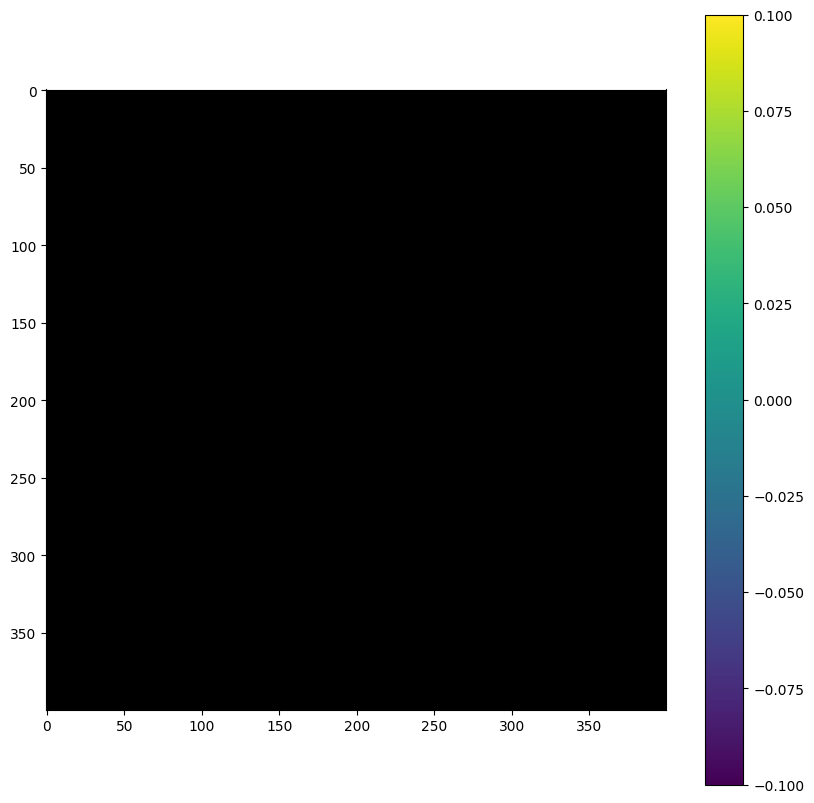


Image statistics:
Mean per channel: [0. 0. 0.]
Std per channel: [0. 0. 0.]
Min per channel: [0. 0. 0.]
Max per channel: [0. 0. 0.]


In [28]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.8'

import importlib
import rendering
importlib.reload(rendering)

# Check model parameters
print("Model parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.mean().item():.4f} (mean), {param.std().item():.4f} (std)")

# Try rendering with debug info
img = rendering.test_render(model, 
                          torch.from_numpy(o[1]).to(torch.float32),
                          torch.from_numpy(d[1]).to(torch.float32),
                          tn=8,  # Back to original values
                          tf=12,
                          nb_bins=100,
                          chunk_size=80,
                          debug=True)

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(img.cpu().numpy())
plt.colorbar()
plt.show()

# Print full stats
print("\nImage statistics:")
flat_img = img.cpu().numpy().reshape(-1, 3)
print(f"Mean per channel: {flat_img.mean(0)}")
print(f"Std per channel: {flat_img.std(0)}")
print(f"Min per channel: {flat_img.min(0)}")
print(f"Max per channel: {flat_img.max(0)}")

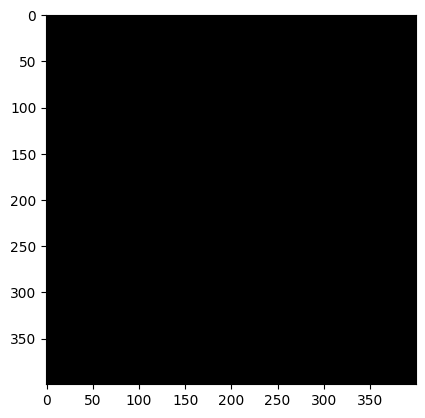

In [29]:
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())

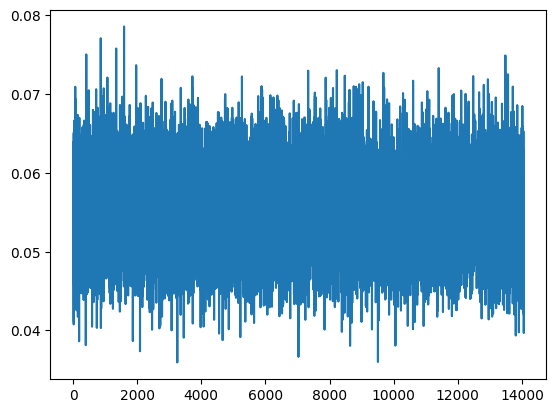

In [14]:
plt.plot(training_loss)
torch.save(model, 'model_nerfs')

# Rendering